# Wait Wait, Don't Analyze Me!

![NPR logo](https://media.npr.org/branding/programs/wait-wait-dont-tell-me/branding_main-c5920a167d6a5d445ce86fac30b90454223b6b57.png "One nerd's attempt to learn everything there is to know about NPR's greatest quiz show.")


# Introduction
[Wait Wait, Don't Tell Me!](https://www.npr.org/programs/wait-wait-dont-tell-me/) is NPR's longest-running news quiz show. Contestents call in to answer questions about the week's news, and a rotating cast of three panelists make jokes and parody newsworthy (and not-so-newsworthy) current events. Listening to "Wait wait" has been a highlight of my week since I was a kid, and it remains one of NPR's most popular segments. So what better way to show my appreciation than to take it apart and see what makes it tick?

For this project, I have pulled text transcripts of each episode of "Wait, Wait", storing them as a MySQL library. I have two goals:
1. Understand and predict jokes in the program.
2. Create a "Wait wait" transcript generator, so that I don't have to wait a whole week between episodes!

# Table of contents

1. [Loading the data](#data-loading)
2. [Line Statistics Predictions](#line-stats)
3. [Word Content Predictions](#words)
4. [Combined Predictions](#combo)
5. [Recurrent Neural Network Predictions](#GRU)
    1. [Data preparation](#rnn-prep)
    2. [Synonyms data augmentation](#rnn-syn)
    3. [Model Generation](#rnn-model)
    4. [Model Training](#rnn-train)
    5. [Model Optimization](#rnn-optimize)
    6. [Attention](#rnn-attention)
    

# Section 0: Loading the data <a name="data-loading"></a>

Before I can analyze the data, I must first load it and process it. To accomplish this, I wrote a simple set of  functions to load in text files containing the transcripts, figure out who the speakers are, and separate the text blocks into a list of words.

For full discussion of these functions, take a look at my previous Jupyter notebook, "WWDA Analyzing text.ipynb".

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import mysql.connector
import re
from sklearn.preprocessing import QuantileTransformer
import time
import matplotlib.cm as cm

from tensorflow.python import keras

os.environ['TF_KERAS'] = 'True'

%matplotlib inline

# change the default font size in figures to be larger
font = {'size'   : 15}

plt.rc('font', **font)

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/cor

In [2]:
# connect to the database of wait wait don't tell me transcripts
cnx = mysql.connector.connect(database='wait_wait',
                              user='root')

In [3]:
# function to pull some transcripts from the database
def pull_transcript(n=5):
    # instantiate a cursor to select data from the database
    curs = cnx.cursor()
    curs.execute(f'select * from transcripts limit {n}')
    
    # pull the data and convert to a pandas dataframe
    df = pd.DataFrame(data = np.array(curs.fetchmany(n)),columns=curs.column_names)
    df = df.set_index('id')
    
    # close the cursor
    curs.close()
    return df

In [4]:
num_transcripts = 4131
transcript_df = pull_transcript(n=num_transcripts)

In [5]:
# We want to go ahead and split the entries into testing, training, and validation sets,
# so that we don't over-fit.
np.random.seed(42)
transcript_df['train'] = np.random.rand(num_transcripts)>.2
transcript_df['val'] = (transcript_df['train']*np.random.rand(num_transcripts))>.8
transcript_df['train'] = transcript_df['train'] & ~transcript_df['val']

In [6]:
# Support function that pulls lines from the transcript and labels them by segment and air date
# Note: I feel I should be able to eliminate the for loop, as this can be somewhat
# time-consuming, but it gets the job done for now.
def extract_lines(transcript_numbers):
    
    # initialize list
    df_list = []
    
    # separate the lines
    lines = transcript_df['transcript'].str.split('\n    ')
    
    # make each line into a row in a dataframe, labeled by transcript number
    for df_idx,line_idx in enumerate(transcript_numbers):
        df_list.append(pd.DataFrame(lines[line_idx],columns=['lines']))
        df_list[df_idx].loc[:,'line_num'] = df_list[df_idx].index
        df_list[df_idx].loc[:,'transcript_id'] = line_idx
    
    # join the lines from all transcripts, and add info from the transcript dataframe
    lines_df = pd.concat(df_list)
    lines_df = lines_df.merge(transcript_df.loc[:,['aired_at','segment','train','val']],
                              left_on='transcript_id',right_on='id',copy=False)
    lines_df.set_index(['transcript_id','line_num'],inplace=True)
    
    return lines_df

In [7]:
def line_info(transcript_numbers):
    
    # extract the transcript, and divide it by lines
    df = extract_lines(transcript_numbers) # turn the lines into a dataframe
    
    # if the line contains "LAUGHTER", mark the previous line as "funny"
    df['funny'] = df['lines'].str.contains('LAUGHTER')
    df['funny'] = df.funny.shift(-1) # need funny to modify the previous line
    
    # if the line contains "APPLAUSE", mark the previous line as "clapping"
    df['clapping'] = df['lines'].str.contains('APPLAUSE')
    df['clapping'] = df['lines'].str.contains('CLAPPING')
    df['clapping'] = df['lines'].str.contains('CHEERING')
    df['clapping'] = df.clapping.shift(-1)

    # for the remaining lines, identify the speaker using regular expressions
    df['speaker'] = df['lines'].str.extract(r'([A-Z]+:)',expand=False).str.replace(r':','')
    df['lines'] = df['lines'].str.replace(r'.+?(?=:)','').str.replace(r':','')
    df['speaker'] = df['speaker'].str.replace('JR','BLOUNT') # disambiguating Roy Blount Jr
    df['speaker'] = df['speaker'].str.replace('HOST','SAGAL') # sometimes refers to Sagal as host
    
    # drop the lines with no speaker (Applause markers, empty lines, etc.)
    df = df.dropna()
    
    # Create a column with the number of separated words
    df['num_words'] = df.lines.str.split().str.len()
    
    # Normalize the number of words with a quantile transformer
    QT = QuantileTransformer(n_quantiles=1000,output_distribution='uniform')
    QT.fit(df.num_words.values.reshape(-1,1)) 
    df['uniform_words'] = QT.transform(df.num_words.values.reshape(-1,1))
    
    # Create a column with whether the previous line was funny (for predictions)
    df['prev_line_funny'] = df.funny.shift(1)

    return df

In [9]:
# Process the training set and show the top of the dataframe
lines_df = line_info(transcript_df.index)
lines_df.head()

lines  \
transcript_id line_num                                                      
1             4          From NPR and WBEZ Chicago, this is WAIT WAIT....   
              6          I'm Bill Kurtis. And here's your host at the ...   
              7                                                             
              10         Thank you so much. We have a very interesting...   
              12         But first, as many of you know, the NPR podca...   

                          aired_at segment  train    val  funny clapping  \
transcript_id line_num                                                     
1             4         2019-05-04     who   True  False   True    False   
              6         2019-05-04     who   True  False  False    False   
              7         2019-05-04     who   True  False  False    False   
              10        2019-05-04     who   True  False   True    False   
              12        2019-05-04     who   True  False   True    False   

                       speaker  num_words  uniform_words prev_line_funny  
transcript_id line_num                                                    
1             4         KURTIS         25       0.837337             NaN  
              6         KURTIS         17       0.737237            True  
              7          SAGAL          0       0.000000           False  
              10         SAGAL         56       0.964464           False  
              12         SAGAL         53       0.958959            True

## 1.1 Setting up the data
Let's get everything into a really nice format for our classifiers.

In [10]:
# Add in the one-hot encoding for speakers
# Convert speaker to categorical
speaker_list = ['BABYLON','BLOUNT','BODDEN','BODETT','BURBANK','BURKE','CONNOR','DICKINSON','FARSAD',
               'FELBER','FERO','GOLDTHWAIT','GROSZ','HONG','JOBRANI','KLEIN','PIERCE','POUNDSTONE','ROBERTS',
               'ROCCA','ROURKE','SALIE','SAGAL','KURTIS','KASELL'] # As found in my previous notebook WWDA Analyzing text

lines_df = pd.concat([lines_df,pd.get_dummies(lines_df.speaker).loc[:,speaker_list]],axis=1)

In [11]:
# Add in the one-hot encoding for speakers
segment_list = lines_df.segment.unique()
lines_df = pd.concat([lines_df,pd.get_dummies(lines_df.segment).loc[:,segment_list]],axis=1)

In [12]:
# Remove lines with no previous line value
lines_df = lines_df.dropna(subset=['prev_line_funny'])

# remove lines with less than five words
lines_df = lines_df[lines_df.num_words>=5]

In [13]:
target = lines_df.loc[lines_df.train,'funny'].astype(int)
line_stats = lines_df.loc[lines_df.train,:].drop(['lines','segment', 'funny', 'clapping', 'speaker', 'num_words','aired_at','train'],axis=1)
line_stats.tail()

val  uniform_words prev_line_funny  BABYLON  BLOUNT  \
transcript_id line_num                                                          
4129          79        False       0.845345           False        0       0   
              82        False       0.663163           False        0       0   
              83        False       0.492492           False        0       0   
4131          15        False       0.783283           False        0       0   
              20        False       0.875876           False        0       0   

                        BODDEN  BODETT  BURBANK  BURKE  CONNOR     ...       \
transcript_id line_num                                             ...        
4129          79             0       0        0      0       0     ...        
              82             0       0        0      0       0     ...        
              83             0       0        0      0       0     ...        
4131          15             0       0        0      0       0     ...        
              20             0       0        0      0       0     ...        

                        SAGAL  KURTIS  KASELL  who  panel  bluff  job  \
transcript_id line_num                                                  
4129          79            1       0       0    0      0      0    0   
              82            0       0       1    0      0      0    0   
              83            1       0       0    0      0      0    0   
4131          15            0       0       0    0      0      0    0   
              20            1       0       0    0      0      0    0   

                        limerick  lightning  predictions  
transcript_id line_num                                    
4129          79               1          0            0  
              82               1          0            0  
              83               1          0            0  
4131          15               0          0            1  
              20               0          0            1  

[5 rows x 35 columns]

# 1.0 Predicting humor based on line statistics  <a name="line-stats"></a>

For a simple attempt at predicting humor, I can assess whether we can predict the funniness of a line based only on line statistics. For the statistics, I'm using the following:
1. Length of line (shifted to have a uniform distribution)
2. Speaker identity (As a one-hot encoding)
3. Was the previous line funny? (funny lines may "cluter")

## 1.2 Non-optimized classifier performance

I'll compare the performance of three types of classifiers: 
1. Logistic regression
2. Naive bayes
3. Decision trees

To determine model performance, I will classify the **log loss**. Measuring model performance based on accuracy can be non-optimal. For example, if the model had the right output but was close to guessing the wrong output, then we would want that outcome to perform worse than if the model had the correct output and was very confident in that guess. Log loss takes into account model certainty as well as accuracy (it operates on the model's predicted probability, and can therefore provide a more nuanced view of model performance.

A support vector machine is also likely to be a good model. However, it doesn't calculate probabilities natively, so I will exclude it for now, and perhaps later compare it to my other models.

In [14]:
# Importing model-generating functions
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB,ComplementNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.svm import SVC

# Importing model evaluation functions
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV,GridSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import log_loss, make_scorer
from sklearn.pipeline import Pipeline
from scipy.stats import randint,uniform

First, it is helpful to determine the performance based on a "just guess the mean" strategy. This will tell us whether we are actually getting anything useful out of our models.

In [15]:
# Naive mean-guessing performance
naive_loss = log_loss(target,target.mean()*np.ones(target.size))
print(f'Loss for mean guessing is {naive_loss}')
print(f'Accuracy for mean guessing is {1-target.mean()}')

Loss for mean guessing is 0.575285541754947
Accuracy for mean guessing is 0.7378579397545556


For my first "simple" classifier, I am using logistic regression. This is a very simple model, which assigns weights and biases to each input variable, and then adds the results together. The final number is then fed through a sigmoid function, to constrain the results between zero and one. It is a classifier generalization of linear regression, and can find simple (linear) relationships between the input variables and the output.

In [ ]:
### logistic regression
lr = LogisticRegression(solver='lbfgs',max_iter=200)
scores_lr=cross_validate(lr,
                       line_stats,
                       target,
                       scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                       cv=10)
print(f'Cross-validated loss for logistic regression is {-scores_lr["test_score"].mean()}')

For my next classifier, I will examine a Naive Bayes classifier. Bayesian inference is a technique which attempts to calculate the probability of each possible category (e.g. the **posterior** probability), given the inputs and its estimate of the typical probability for each category (e.g. the **prior** probability). So, for example, in this case we have approximately four times as many "not funny" lines as "funny" lines, so the model would need more evidence in order to make a judgement that a line is funny than it would need to make a judgement that a line is not funny. 

A Naive bayes classifier makes the further assumption that all of the input variables are **independent** of each other. This is not strictly true in this dataset. For example, the speakers are all negatively correlated - if one speaker has said a line, then another speaker cannot have said it. Regardless, we can examine how well the classifier works on our dataset before we move to more complicated models.

In [ ]:
# naive bayes
nb = MultinomialNB()
scores_nb=cross_validate(nb,
                       line_stats,
                       target,
                       scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                       cv=10)
print(f'Cross-validated loss for naive bayes is {-scores_nb["test_score"].mean()}')

I will now examine two quite complex classifiers, based on **decision trees**. Decision trees take in the data, and then attempt to split it based on the input into two leaves. Each leaf is then split again (and again), until the data can be classified as well as possible. These models are good at capturing complex nonlinearities, but can also be prone to over-fitting, as they are highly complex with many parameters. 

One way of getting around these weaknesses is by using a **Random Forest**. A forest, as the name might suggest, is a combination of many trees. Each tree only sees a subset of the input data and a subset of the input parameters, and so will make a sub-optimal decision. But by averaging these biased decisions of all of the trees together, we can usually wind up with a more-accurate answer in the end, as the biases will cancel out on average. 

In [33]:
# Random forest
rf = ExtraTreesClassifier()
scores_rf=cross_validate(rf,
                       line_stats,
                       target,
                       scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                       cv=3)
print(f'Cross-validated loss for random forest is {-scores_rf["test_score"].mean()}')

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cross-validated loss for random forest is 1.653541920549183


A second method for improving deicision trees is called **Gradient boosted trees.** This is also an ensemble method, which trains multiple classifiers to improve performance. Unlike the Random Forest, however, Gradient Boosted Trees calculates a sequence of classifiers. Each one is trained to improve the output of the previous one (by looking at the prediction residuals), so it is specifically formulated to improve performance with the addition of each tree. Whereas Random Forests tend to benefit from large, deep trees, Gradient boosted tree classifiers tend to put together many small, shallow trees (e.g. not many splits of the data performed by any given tree). 

In [34]:
# Gradient boosted trees
xgb = GradientBoostingClassifier()
scores_xgb=cross_validate(xgb,
                       line_stats,
                       target,
                       scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                       return_estimator=True,
                       cv=3)
print(f'Cross-validated loss for gradient boosted trees is {-scores_xgb["test_score"].mean()}')


Cross-validated loss for gradient boosted trees is 0.5153023754563527


So, out-of-the-box performance is best for Gradient boosted trees, followed by Logistic Regression (keep in mind that small loss = better). The Random Forest performs worse than a mean-guessing strategy, while the naive bayes model performs only ever so slightly better.

What we would really want to do, of course, is to perform a **parameter sweep** to select the best parameters for each model. Fortunately, scikit-learn has ways of doing exactly that. So let's try a parameter sweep now, and see how our "best" model that we can find for each model type performs.

## 1.3 Parameter optimization via random search

To optimize parameters for each function, we have a couple of options: Grid Search or Random Search. Both search methods build multiple models with different parameters. 

**Grid Search** exhaustively checks every combination of parameters you specify. For example, if you have three parameters, each of which could take three values, then there are 3^3, or 27 different possible combinations to check.

**Random Search** instead builds many models, each time selecting a random value for the parameters. While this might initially seem less useful than grid search, it has a few advantages that I like. It can check more values for each parameter. Parameters that have more influence will wind up affecting the output more, and less time will be wasted exhaustively checking the parameters which wind up being unimportant. 

For a nice discussion of Random Search versus Grid Search, see this paper: [Bergstra & Bengio, 2012](http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf).

### 1.3.1 Preparing Summary Function

First, I build a function that will show the results of my optimization, so that I can examine how important each parameter is, and compare model performance.

In [15]:
# This is a function which shows how model performance changes with each parameter individually.
# Note: it will not capture interactions between parameters, but will give a decent "high level" sense
# of how much each parameter seems to matter to model performance on its own

def Plot_results(random_search):
    
    print(f'Best performance was {-random_search.best_score_}')
    for key in random_search.best_params_.keys():
        print(f'Best model value for {key} = {random_search.best_params_[key]}')
    
    # Plot the results
    random_search_results = pd.DataFrame(random_search.cv_results_)
    params = random_search_results.loc[0,'params'].keys()
    plt.figure(figsize=(5*len(params),10))
    
    for i,param in enumerate(params):
        try:
            plt.subplot(2,len(params),i+1)
            plt.axis('tight')
            plt.scatter(random_search_results['param_' + param].apply(np.max),-random_search_results['mean_test_score'])
            plt.xlabel(param)
            plt.ylabel('log loss')
            plt.axis('tight') # This is a repeat - for some reason axis is too zoomed out without both.

            plt.subplot(2,len(params),i+1+len(params))
            x = random_search_results['param_' + param].apply(np.max) # Max deals with n-gram parameter, which is a tuple
            y = random_search_results['mean_fit_time']
            plt.scatter(x,y)
            plt.xlabel(param)
            plt.ylabel('run time')
        except:
            continue


### 1.3.2 Optimizing Logistic Regression

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 11] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 13] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/Users/coraames/git/BimanualMod

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 13] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 11] are constant.
  UserWarning)
/Users/coraames/git/BimanualMod

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 13] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 11] are constant.
  UserWarning)
/Users/coraames/git/BimanualMod

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 13] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 11] are constant.
  UserWarning)
/Users/coraames/git/BimanualMod

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 13] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 11] are constant.
  UserWarning)
/Users/coraames/git/BimanualMod

Best performance was 0.5342955482956562
Best model value for kbest__k = 28
Best model value for lr__max_iter = 107


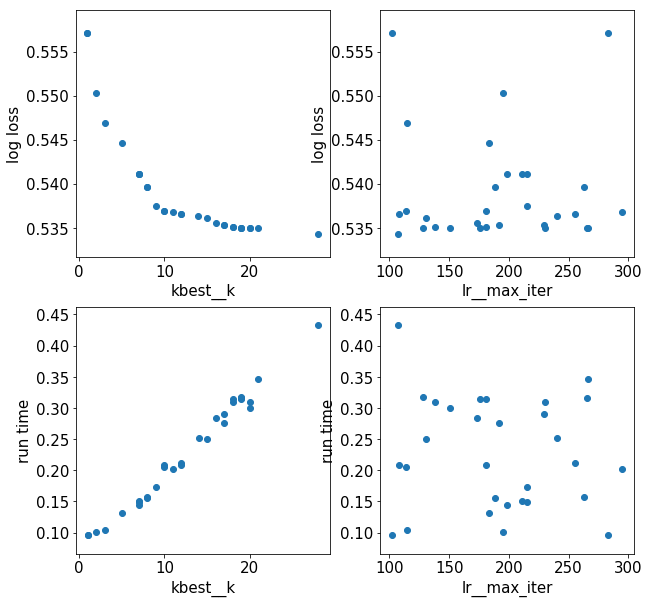

In [36]:
# logistic regression

# Build the pipeline
lr_pipeline = Pipeline([
    ('kbest', SelectKBest(k=20,score_func=f_classif)),    # subselect the best k predictors (based on )
    ('lr',LogisticRegression(solver='lbfgs',max_iter=200)),
    ])

# select parameters to tune
lr_params = {
    'kbest__k': randint(1,30),
    'lr__max_iter':randint(100,300),
}

# Iteratively check parameters (randomized)  
n_iter = 30
random_search = RandomizedSearchCV(lr_pipeline,
                                   param_distributions=lr_params,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=0,
                                   refit=0,
                                   return_train_score=True
                                  )
random_search.fit(line_stats.astype('float64'),target)
Plot_results(random_search)

### 1.3.3 Optimizing Naive Bayes

Best performance was 0.5549909307867035
Best model value for nb__alpha = 10.0
Best model value for nb__fit_prior = True


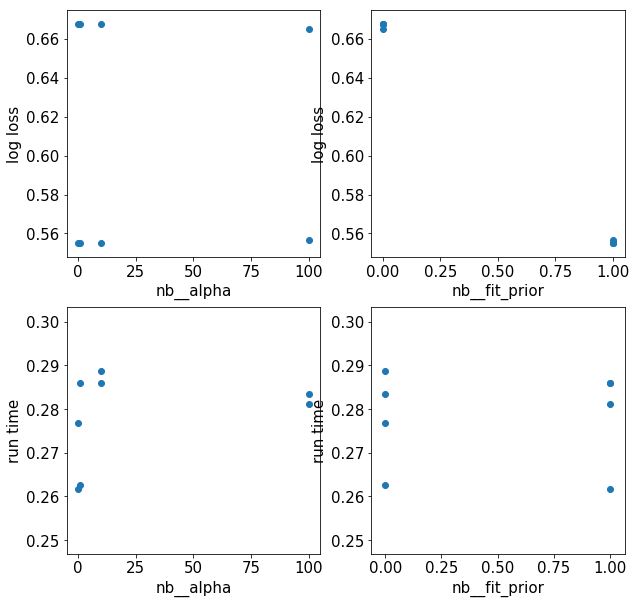

In [37]:
# naive bayes

# Build the pipeline
nb_pipeline = Pipeline([
    ('nb',MultinomialNB()),
    ])

# select parameters to tune
nb_params = {
    'nb__fit_prior': [True,False],
    'nb__alpha':[0.1,1.0,10.0,100.0]
}

# Iteratively check parameters (randomized)  
random_search = GridSearchCV(nb_pipeline,
                                   param_grid=nb_params,
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=0,
                                   refit=0,
                                   n_jobs=-1,
                                   return_train_score=True
                                  )
random_search.fit(line_stats,target)
Plot_results(random_search)

### 1.3.4 Optimizing Random Forest

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


Best performance was 0.5006179522082107
Best model value for rf__max_depth = 25
Best model value for rf__min_samples_leaf = 1
Best model value for rf__min_samples_split = 120


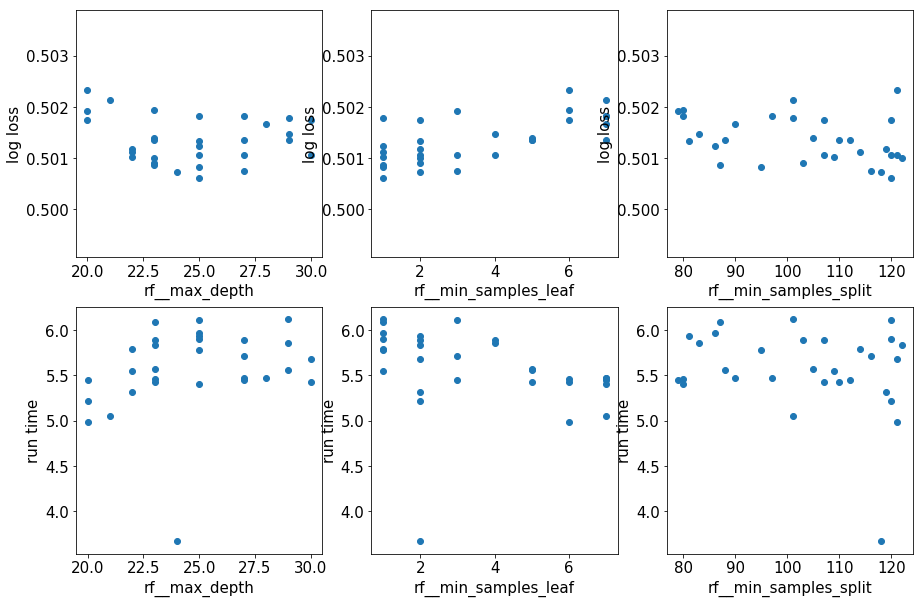

In [38]:
# Extra Trees

# Build the pipeline
rf_pipeline = Pipeline([
    ('rf',ExtraTreesClassifier(n_estimators=50)),
    ])

# select parameters to tune
rf_params = {
    'rf__max_depth': randint(20,31),
    'rf__min_samples_split' : randint(75,125),
    'rf__min_samples_leaf' : randint(1,8),
#     'rf__n_estimators' : randint(50,150)
}

# Iteratively check parameters (randomized)  
n_iter = 30
random_search = RandomizedSearchCV(rf_pipeline,
                                   param_distributions=rf_params,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=1,
                                   refit=0,
                                   n_jobs=-1,
                                   return_train_score=True
                                  )
random_search.fit(line_stats,target)

# Report performance
Plot_results(random_search)


### 1.3.5 Optimizing Gradient Boosted Trees

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.6min finished


Best performance was 0.5033868705048196
Best model value for rf__min_samples_leaf = 5
Best model value for rf__n_estimators = 90
Best model value for rf__subsample = 0.75


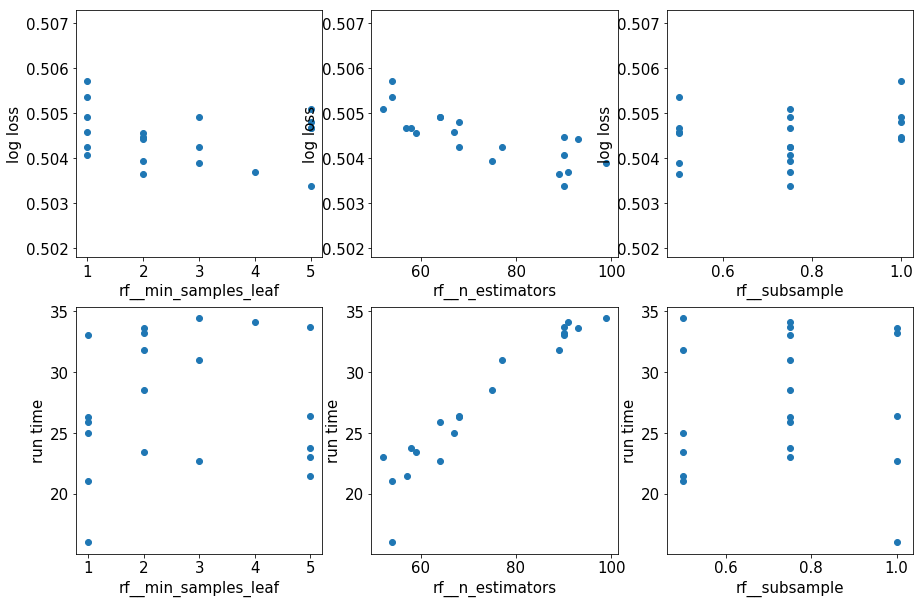

In [39]:
# Gradient Boosted Trees

# Build the pipeline
xgb_pipeline = Pipeline([
    ('rf',GradientBoostingClassifier(max_depth=6)),
    ])

# select parameters to tune
xgb_params = {
    'rf__min_samples_leaf' : randint(1,6),
    'rf__n_estimators' : randint(50,100),
    'rf__subsample' : [.5,.75,1]
}

# Iteratively check parameters (randomized)  
n_iter = 20
random_search = RandomizedSearchCV(xgb_pipeline,
                                   param_distributions=xgb_params,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=1,
                                   refit=0,
                                   n_jobs=-1,
                                   return_train_score=True
                                  )
random_search.fit(line_stats,target)

# Report performance
Plot_results(random_search)

### 1.3.6 Optimization Summary

I found that optimizing the simpler regressors (Naive Bayes, Logistic Regression) does not significantly improve their performance. This tends to be the case, that the simpler the model, the less hyperparameter selection tends to matter. Indeed, there are often many fewer hyper-parameters to optimize in the first place.

The Random Forest improves a great deal with parameter optimization. This indicates that this model is actually able to generate accurate predictions, but the "default" parameters are not good choices for this particular dataset.

The Gradient Boosted trees improve slightly with optimizaiton, but less dramatically so. The default parameters for this function already generated good performance (relative to the other predictors), so there was less room for improvement.

#### The **final performance** of each of my classifiers, predicting humor based on line statistics, is:
1. **Random Forest**: 0.50
2. **Gradient Boosted Trees**: 0.50
3. **Logistic Regression**: 0.53
4. **Naive Bayes**: 0.55

## 1.4 Predicting humor based on words <a name="words"></a>

My next goal is to predict whether a line is funny by actually looking at the words of the line, rather than just statistics about the speaker, line length, and segment.

This can be quite a complicated process, as sentences need a decent amount of processing before a classifier can examine them. I'm going to use a **Bag of words** strategy (which builds a single vector that is the "average" of the words in each line), which performs the following steps:
1. Construct a vector of dimension num_words, where the value is the number of times each word appears in the sentence.
2. Transform this vector based on word frequency, where words that are uncommon across all of the lines are weighted as more important than common words. So the word "Rutabega", for example, would be weighted more strongly than the word "The."
3. Perform unsupervised dimensionality reduction to project the vectors into a smaller space that captures most of the variance.
4. Feed the resulting vectors into the classifier.

For this section, I will only be examining the "forest" style classifiers. This is largely because simple, largely linear classifiers are unlikely to be able to capture the relationship between words and humor - it's a much more complicated space than those classifiers are designed to capture. 

In [40]:
print(f'Loss for mean guessing is {naive_loss}')
print(f'Dumb guessing yields accuracy of {1-target.mean()}')

Loss for mean guessing is 0.575285541754947
Dumb guessing yields accuracy of 0.7378579397545556


### 1.4.1 Random Forest 


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.3min finished


Best performance was 0.5100794492079416
Best model value for clf__max_depth = 40
Best model value for clf__min_samples_leaf = 1
Best model value for clf__min_samples_split = 23
Best model value for tsvd__n_components = 90


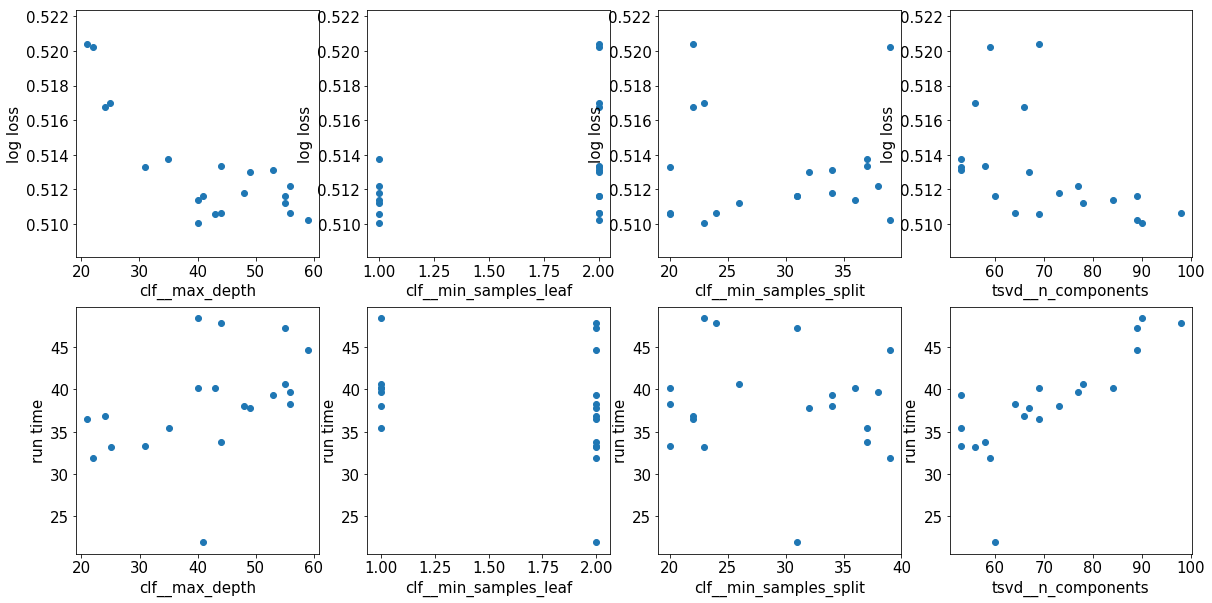

In [41]:
tree_text_pipeline = Pipeline([
     ('vect', CountVectorizer(max_df=.9,min_df=100,ngram_range=(1,3))),
     ('tfidf', TfidfTransformer()),
     ('tsvd',TruncatedSVD(n_components=50)),
     ('clf', ExtraTreesClassifier(n_estimators=50))
  ])

param_dict = {
#     'vect__ngram_range': [ (1, 2), (1, 3),(1,4)],
    'tsvd__n_components':randint(50,100),
    'clf__max_depth': randint(20,60),
    'clf__min_samples_split' : randint(20,40),
    'clf__min_samples_leaf' : randint(1,3),
}

n_iter = 20

random_search = RandomizedSearchCV(tree_text_pipeline,
                                   param_distributions=param_dict,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,
                                                       needs_proba=True,
                                                       greater_is_better=False),
                                   verbose=2,
                                   return_train_score=False,
                                   n_jobs=-1,
                                   refit=0,
                                  )

# random_search.fit(lines_df.loc[lines_df.train,'lines'],
#                   lines_df.loc[lines_df.train,'funny'].astype(int));


entries = (lines_df.train )
# entries = (lines_df.train )& (lines_df.num_words>20)
x = lines_df.loc[entries,'lines'].apply(lambda x: ' '.join(x.split()[-10:])) # last 10 words in each line
# x = lines_df.loc[entries,'lines']
y = lines_df.loc[entries,'funny'].astype(int)
random_search.fit(x,y);

Plot_results(random_search)

### 1.4.2 Gradient Boosted Trees
Note: the scikit-learn implementation of gradient boosted trees is quite slow, especially as the number of inputs to consider increases. A more-optimized method like LightGBM might do better here.

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 59.3min finished


Best performance was 0.5129964686340617
Best model value for clf__max_depth = 4
Best model value for clf__n_estimators = 357
Best model value for clf__subsample = 0.75
Best model value for tsvd__n_components = 102


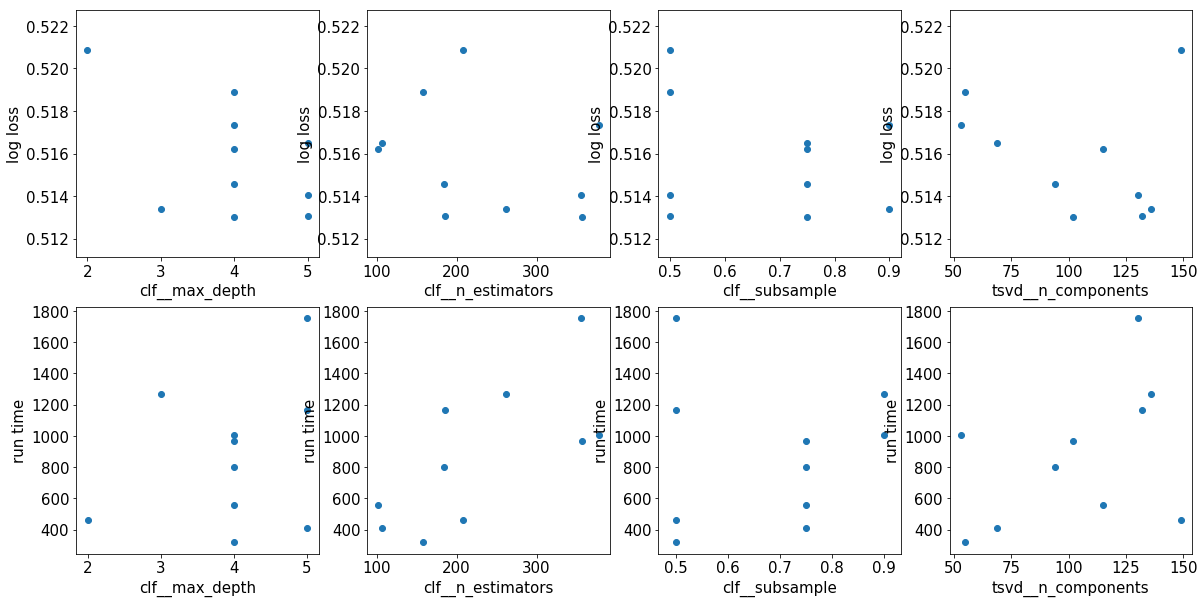

In [42]:
tree_text_pipeline = Pipeline([
     ('vect', CountVectorizer(max_df=.9,min_df=100,ngram_range=(1,2))),
     ('tfidf', TfidfTransformer()),
     ('tsvd',TruncatedSVD(n_components=50)),
     ('clf', GradientBoostingClassifier(n_estimators=10,max_depth=4))
  ])

param_dict = {
    'tsvd__n_components':randint(50,150),
    'clf__n_estimators': randint(100,400),
    'clf__max_depth':randint(2,6),
    'clf__subsample' : [.5,.75,.9]
}

n_iter = 10

random_search = RandomizedSearchCV(tree_text_pipeline,
                                   param_distributions=param_dict,
                                   n_iter=n_iter, 
                                   cv=3, 
                                   iid=False,
                                   scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                                   verbose=2,
                                   return_train_score=False,
                                   n_jobs=-1,
                                   refit=1,
                                  )


entries = (lines_df.train )
x = lines_df.loc[entries,'lines'].apply(lambda x: ' '.join(x.split()[-10:])) # last 10 words in each line
y = lines_df.loc[entries,'funny'].astype(int)
random_search.fit(x,y);

Plot_results(random_search)

### 1.4.3 Text Prediction Conclusions

Both methods were able to perform well at predicting humor based on the text of the lines. This is still a relatively "rough" way of looking at line content, since it doesn't know anything about word order, so it would likely be possible to take that information into account as well, in order to improve performance.

At this stage, the classifiers perform at:

1. **Random Forest: loss = 0.51**
2. **Gradient Boosted Trees: loss = 0.51**

## 1.3 Combining stats and text for prediction <a name="combo"></a>
Often, models can do best when they can take into account as much information about the data as possible. In fact, my previous models performed similarly well using two (largely but not entirely independent) sources of information: the text of the line, and statistics about the line. This indicates that we are **likely to perform better if we combine both sources of information.** So my next step is to incorporate what I have learned from the previous sections, and build a "mega predictor" that takes in both the line text and the line statistics in order to make the best combined prediction.

This requires a slightly more complicated pipeline. Essentially, I'll first build a pipeline to transform the text - this will have the same parameters as I selected for the "optimal" text transformer above. I will then build a second transformer which selects some columns of the input dataframe to pass directly to the classifier, and passes the "lines" column to the text-processing pipeline first. Finally, I bring the full transformer together with the classifier to build the final, complete pipeline. Then, pulling in the data, transforming it, and classifying it will all be performed automatically by the final pipeline.

In [43]:
from sklearn.compose import ColumnTransformer

# I will build a transformer to treat columns in different ways:
text_col = 'lines' # encode and process the words
passthrough_col = ['num_words', 'uniform_words', 'prev_line_funny', 'BABYLON', 'BLOUNT',
       'BODDEN', 'BODETT', 'BURBANK', 'BURKE', 'CONNOR', 'DICKINSON', 'FARSAD',
       'FELBER', 'FERO', 'GOLDTHWAIT', 'GROSZ', 'HONG', 'JOBRANI', 'KLEIN',
       'PIERCE', 'POUNDSTONE', 'ROBERTS', 'ROCCA', 'ROURKE', 'SALIE', 'SAGAL',
       'KURTIS', 'KASELL', 'who', 'panel', 'bluff', 'job', 'predictions',
       'limerick', 'lightning'] # pass through stats/speakers/segment

# Transformation specifically for the line text
text_transformer = Pipeline([
     ('vect', CountVectorizer(min_df=100,max_df=.9,ngram_range=(1, 3))),
     ('tfidf', TfidfTransformer()),
     ('tsvd',TruncatedSVD(n_components=100)),
  ])

# Transform the text and pass the statistics
full_transformer= ColumnTransformer([
    ("text",text_transformer,text_col),
    ("pass","passthrough",passthrough_col)
])

# Pipeline first uses the full_transformer, then the classifier
full_pipeline = Pipeline([
     ('transform',full_transformer),
     ('clf', ExtraTreesClassifier(max_depth=90,n_estimators=200,min_samples_leaf=2))
  ])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 17.9min finished


Best performance was 0.4468755616280024
Best model value for clf__max_depth = 79
Best model value for clf__min_samples_leaf = 2
Best model value for clf__n_estimators = 194


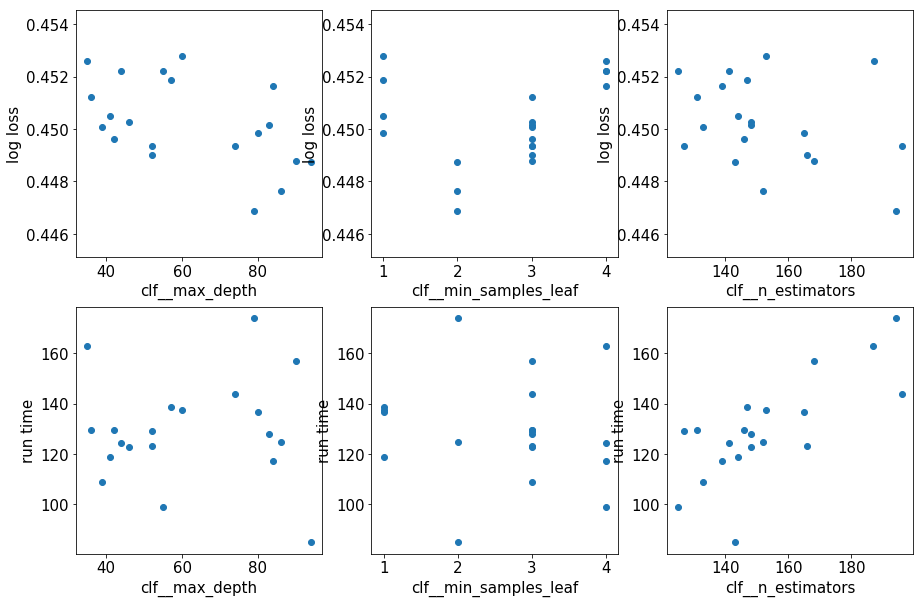

In [44]:
param_dict = {
          'clf__max_depth': randint(30,100),
          'clf__n_estimators': randint(120,200),
          'clf__min_samples_leaf':[1,2,3,4],
}
n_iter = 20

search = RandomizedSearchCV(full_pipeline,
                           param_distributions=param_dict,
                           cv=3,
                           n_jobs=-1,
                           n_iter = n_iter,
                           iid=False,
                           scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                           verbose=2,
                           return_train_score=False,
                           refit=False,
                          )
search.fit(lines_df.loc[lines_df.train,:],target[lines_df.train]);
Plot_results(search)

In [45]:
scores = cross_validate(full_pipeline,
                       X=lines_df.loc[lines_df.train,:],
                       y=lines_df.loc[lines_df.train,'funny'].astype('int'),
                       scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                       cv=10,
                       n_jobs=-1,
                       return_train_score=False,
                   )

print(f"Cross-validated loss for full pipeline is {-scores['test_score'].mean()}")

Cross-validated loss for full pipeline is 0.4261526177965579


## 1.4 Predict the test set

Finally, let's combine everything we learned in the above sections. I'll attempt to build the best model that I can. In this case, that will be a random forest, which receives both line statistics and the text of the lines themselves. I will train it on the full training set, and then evaluate it on the testing set.

In [46]:
final_pipeline = full_pipeline.fit(X=lines_df.loc[lines_df.train,:],
                       y=lines_df.loc[lines_df.train,'funny'].astype('int'))

y_test = lines_df.loc[~lines_df.train,'funny'].astype('int')
X_test = lines_df.loc[~lines_df.train,:]
y_prob = final_pipeline.predict_proba(X_test)
y_pred = final_pipeline.predict(X_test)

# Report performance
print(f'Test set predicted with {(y_pred==y_test).mean()*100}% accuracy.')
print(f'Test score (log loss) is {log_loss(y_test,y_prob)}.')

Test set predicted with 84.96195029968348% accuracy.
Test score (log loss) is 0.3572433495939772.


Our final predictor improves a great deal compared with our "just guess the mean" approach. We get just under 85% accuracy on the test set (compared with a simple guessing accuracy of 74%), and our cross-validated log-loss is much better, at only 0.42 (compared with 0.57 by guessing the average value). This means that not only is the predictor doing a pretty good job of understanding whether or not a line will be funny, but it also has a good estimate of certainty. 

# 2 Predicting Humor with Neural Networks <a name="GRU"></a>

One major challenge with our previous approach is that the text analysis we were capable of doing was relatively course. Because we did not consider word ordering at all, we are potentially missing a great deal of important information contained in the text. While statistical analyses like the ones used above can be quite useful, neural network architectures can be beneficial to learn time-dependent functions and thus gather more detailed information from a block of text. I will therefore move now to training neural networks to predict whether or not a line was funny, and see how well I can do with this approach.

The type of neural network I will be using is called a Recurrent Neural Network (RNN). Instead of being ordered in feed-forward layers, recurrent neural network layers connect with themselves over time, and thus can take time-varying inputs into account. The specific type of RNN I will be using is called a GRU (Gated Recurrent Units). These units have a hidden state which can be either held onto or updated at each time step, depending on the state of the network and the inputs. This architecture helps the network to take longer-scale time information into account (traditionally a major challenge with "basic" recurrent neural networks.) 

This section was closely based on [this tutorial](https://keras.io/examples/pretrained_word_embeddings/), although I have made a number of small changes as I have been playing with the data.

## 2.1 Preparing the inputs<a name=#rnn-prep></a>

In order to feed the lines into the neural networks, I must perform a number of preprocessing steps. 
1. **[GloVe Embeddings](https://nlp.stanford.edu/projects/glove/)** (Global Vectors for Word Representation) are pre-trained vectors that embed words in a high-dimensional space, such that "similar" words will be close together. These embeddings were trained on Wikipedia articles, and therefore have a sense of typical english language structure. Using a pre-trained embedding can help to get text input data into a useful structure for subsequent learning.
2. **Data augmentation**: It can often be useful to try to train neural networks on as many training examples as possible. A good way to add additional data to text is to take the training data and replace some of the words with synonyms. This (usually) doesn't change the nature of the sentence, but adds some nice variation and helps reduce over-fitting. I'll generate two extra versions of each training example via random synonym replacement.
3. **Sentence padding**: Recurrent neural networks typically need to be trained with inputs that have the same number of words (at the very least, each batch must contain the same dimensions of input). But my lines can vary from a single word to several hundred words in length. So, I will for the moment cut every sentence to a maximum of 50 words long. For those sentences that are shorter than 50 words, I will add a "filler word" to grow them to 50 words long. Because the end of the sentence is likely to be more informative about funniness than the beginning, I will keep the last 50 words of each sentence, rather than the first 50 words of each sentence.

In [117]:
# First, load all of the libraries I'll be using in this section
from __future__ import print_function

import os
import sys
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding,Flatten,SpatialDropout1D
from tensorflow.keras.layers import GRU,Bidirectional,Lambda,Add
from tensorflow.keras.layers import Dropout,Concatenate,BatchNormalization,Add,GaussianNoise,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adadelta, Adam, Nadam
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import L1L2

In [118]:
#### establish some constants/meta parameters
BASE_DIR = './'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
MAX_SEQUENCE_LENGTH = 50
MAX_VOCABULARY = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

### Process input for model
- Tokenize words
- Separate x (word tokens) from y (funniness boolean)
- Get training and validation sets
- Extract an embedding matrix from GLOVE embeddings to be used by the model

In [119]:
# Function to take the training data and divide it into x (lines) and y (funniness)
def Segment_input(lines_df, min_words=0,max_words = float('inf')):
    
    # subselect to lines whose length is at least min_words and at most max_words
    lines_to_use = (lines_df.num_words>=min_words) & (lines_df.num_words<=max_words)
    
    # list of text samples
    x = lines_df[lines_to_use].lines.values  
    
    # Whether or not each trial is funny
    y = lines_df[lines_to_use].funny.values 
    
    # predict other information about the lines, for cross-training
    y_segment = lines_df.loc[lines_to_use,segment_list].values 
    y_speaker = lines_df.loc[lines_to_use,speaker_list].values 

    return x,y,y_segment,y_speaker


In [120]:
# take in the lines in the training and validation sets, and encode it as a series of integers
def Encode_lines(x_list,max_num_words = MAX_VOCABULARY,sequence_length = MAX_SEQUENCE_LENGTH):
    tokenizer = Tokenizer(num_words=MAX_VOCABULARY,lower=True,oov_token=0)
    tokenizer.fit_on_texts(np.concatenate(x_list))
    word_index = tokenizer.word_index

    # Encode each of the inputs
    x_encoded = []
    for x in x_list:
        x_encoded.append(Encode_and_pad(x,tokenizer,MAX_SEQUENCE_LENGTH))
        
    return x_encoded,word_index

# support function for Encode_lines (apply encoder to lines, crop all lines to the same length)
def Encode_and_pad(x,tokenizer,sequence_length):
    sequences = tokenizer.texts_to_sequences(x)
    x_encoded = pad_sequences(sequences,truncating='post', maxlen=sequence_length) # keep the end of the lines
    return x_encoded

In [121]:
# Make the embedding matrix
def Make_embedding_matrix(word_index):
    # Create a dictionary mapping words to GLOVE embeddings
    print('Indexing word vectors.')
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt')) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
    
    # Prepare embedding matrix
    num_words = min(MAX_VOCABULARY, len(word_index)) + 1
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > MAX_VOCABULARY:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [122]:
# Wrapper function to take in a lines data structure, and 
# output training and validation sets and the GLOVE embedding matrix
    # Inputs:
    # lines_df: data structure of lines, as generated above.
    # min_words: the minimum length of a line to be included
    # max_length: the maximum length of a line to be included
    # max_num_words:
def Process_data(lines_df, min_words=20,max_length = MAX_SEQUENCE_LENGTH,
                 max_num_words = MAX_VOCABULARY):
    
    # Get the x/y data for training and validation sets
    x_train,y_train,y_segment,y_speaker = Segment_input(lines_df.loc[lines_df.train,:],min_words=min_words)
    x_val,y_val,y_segment_val,y_speaker_val = Segment_input(lines_df.loc[lines_df.val,:],min_words=min_words)
    x_test,y_test,_,_ = Segment_input(lines_df.loc[~lines_df.train & ~lines_df.val,:],
                                  min_words=min_words)

    y_crosstrain = [[y_segment,y_segment_val],[y_speaker,y_speaker_val]]
    
    # Encode words as integers
    [x_train_encoded,x_val_encoded,x_test_encoded],word_index = \
        Encode_lines([x_train,x_val,x_test])
    
    # Make an embedding matrix
    embedding_matrix = Make_embedding_matrix(word_index)
    
    return x_train,x_train_encoded,y_train,x_val,x_val_encoded,y_val,x_test,x_test_encoded,y_test,embedding_matrix,y_crosstrain



In [132]:
x_train,x_train_encoded,y_train,x_val,x_val_encoded,y_val,x_test,x_test_encoded,y_test,embedding_matrix,y_crosstrain = Process_data(lines_df,min_words=1,max_length=30)

print(f'Created {y_train.size} training samples.')
print(f'Average value of training set: {y_train.mean()}')

Indexing word vectors.
Found 400000 word vectors.
Created 107560 training samples.
Average value of training set: 0.2621420602454444


### 1-d convolutional model

In [124]:
from keras_multi_head import MultiHead
from tensorflow.keras.layers import Reshape, SpatialDropout1D

In [24]:
def plot_training(history):
    history = history.history
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1,2,2)
    plt.plot(history['categorical_accuracy'])
    plt.plot(history['val_categorical_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

In [ ]:
# define a model building function, with some hyper-parameters to optimize
def Segment_CNN(dropout_rate=0,num_hidden=32,num_layers=2,optimizer='adam',learn_embedding=False):
    
    # load pre-trained word embeddings into an Embedding layer
    embedding_layer = keras.layers.Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=learn_embedding)
    
    # embedding 
    model = keras.models.Sequential()
    model.add(embedding_layer)
    model.add(keras.layers.SpatialDropout1D(rate=dropout_rate))

    # first convolutional layer
    for layer in range(num_layers):
        model.add(MultiHead([keras.layers.Conv1D(num_hidden,kernel_size=1,padding='same'),
                         keras.layers.Conv1D(num_hidden,kernel_size=3,padding='same'),
                         keras.layers.Conv1D(num_hidden,kernel_size=5,padding='same'),
                        ]))
        model.add(keras.layers.Activation('relu'))
        model.add(keras.layers.Reshape([MAX_SEQUENCE_LENGTH,num_hidden*3]))
        model.add(keras.layers.SpatialDropout1D(rate=dropout_rate))
        model.add(keras.layers.MaxPooling1D(2))
        model.add(keras.layers.BatchNormalization())


    model.add(keras.layers.GlobalMaxPool1D())

    # Readout layer
    model.add(keras.layers.Dense(num_hidden,activation='relu'))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
                  
    return model


In [38]:
# Build a wrapper for the network, so that we can optimize its hyperparameters using sklearn
sklearn_CNN = keras.wrappers.scikit_learn.KerasClassifier(build_fn=Segment_CNN)

# Specify hyperparameters - typically a range, 
# although can also set single values for hyperparameters we don't want to modify
param_dict = {'dropout_rate': uniform(0,.5),
              'num_hidden': randint(32,128),
              'batch_size':randint(32,128),
              'epochs':randint(3,7),
              'optimizer':['adam','nadam','rmsprop'],
              'verbose':[0],
              'learn_embedding':[True,False]
}

# Perform several iterations over the hyperparameter space
n_iter = 10
search = RandomizedSearchCV(estimator=sklearn_CNN,
                           param_distributions=param_dict,
                           cv=3,
                           n_jobs=-1,
                           n_iter = n_iter,
                           iid=False,
                           scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                           verbose=2,
                           return_train_score=False,
                           refit=False,
                          )
search.fit(x_train_encoded,y_train.astype('int'));
# Plot_results(search)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 96.9min finished


Best performance was 0.4750798927611
Best model value for batch_size = 98
Best model value for dropout_rate = 0.30259903646835906
Best model value for epochs = 4
Best model value for learn_embedding = True
Best model value for num_hidden = 102
Best model value for optimizer = rmsprop
Best model value for verbose = 0


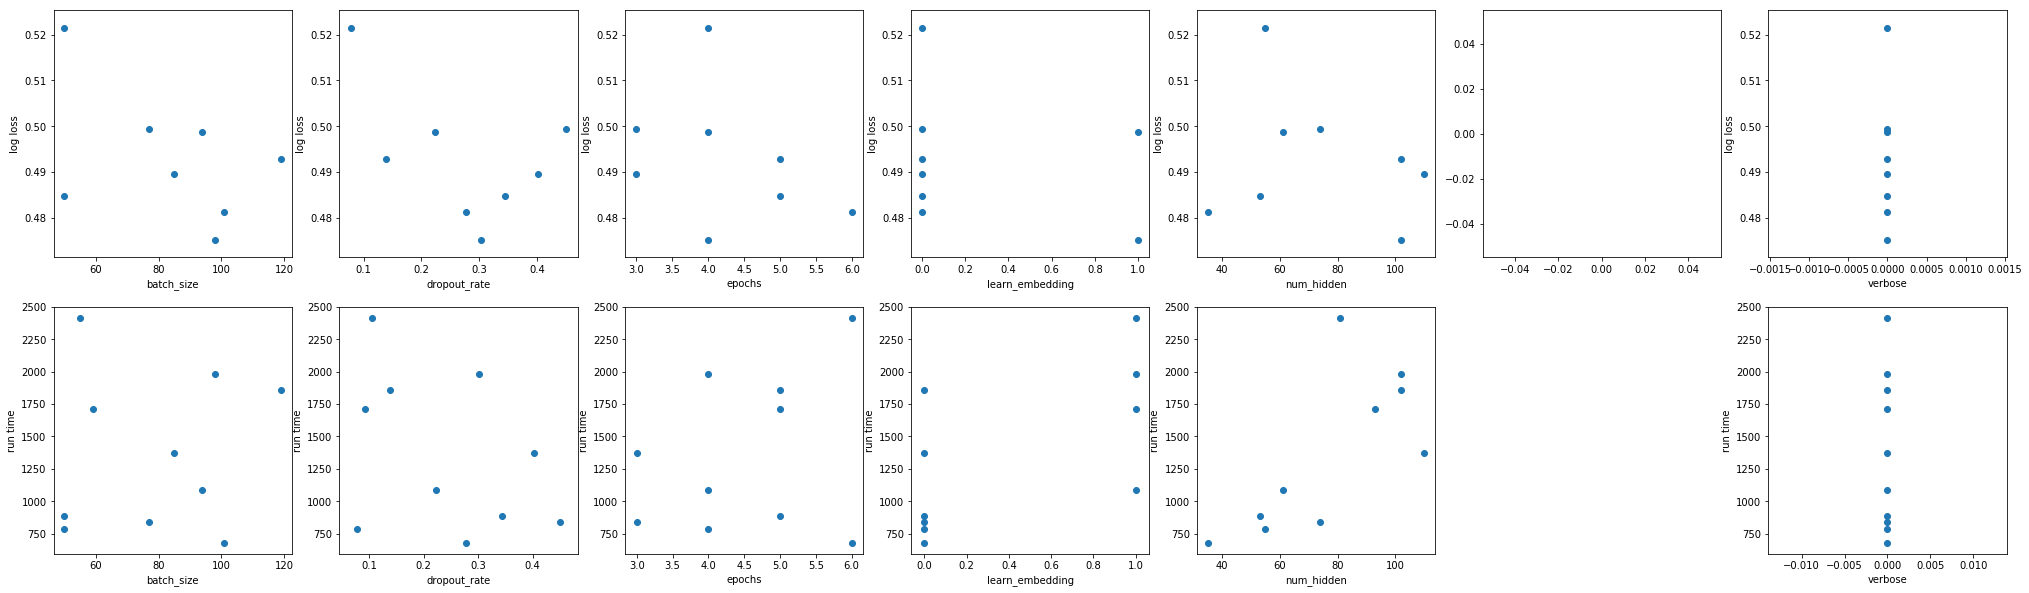

In [149]:
Plot_results(search)

## 2.1 Non-optimized model <a name='rnn-model'></a>
The next step is to take these processed inputs, and generate a model. 
This model has a few properties that I have found useful through trial-and-error testing with my training and validation sets.
1. **Dropout**: Because neural networks tend to have many, many parameters, they are prone to "overfit" - memorizing the training data instead of learning properties that generalize to new data points. One way of preventing overfitting is to use dropout during training - randomly removing some units or connections, to ensure that the output is not overly reliant on the exact values of any one of its internal parameters.
2. **Bidirectional Layers**: This means that I have one network that runs forward on the data, and one network that runs backward on the data. This gives a better sense of each word in context - informed not only by the words that come before, but also by those that come after.
3. **Two GRU layers**: More than that seems not to be helpful. In theory, multiple layers ought not to be necessary, but in practice I find that it helps. Perhaps it can help the system to capture more nonlinearities in the relationship between words, locations, and humor. 

In [24]:
from keras_self_attention import SeqSelfAttention
from keras_multi_head import MultiHeadAttention,MultiHead

In [133]:
# define a model building function, with some hyper-parameters to optimize
def Generate_RNN(dropout_rate=0.5,num_hidden=32,optimizer='adam',num_heads=1,num_layers=3,learn_embedding=True,noise=0.1):
    
    # load pre-trained word embeddings into an Embedding layer
    embedding_layer = keras.layers.Embedding(embedding_matrix.shape[0],
                            64,
#                             embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=learn_embedding)
    
    # embedding 
    model = keras.models.Sequential()
    model.add(embedding_layer)
    model.add(keras.layers.GaussianNoise(noise))

    # first RNN layer
    for layer in range(num_layers):
        model.add(keras.layers.SpatialDropout1D(rate=dropout_rate))
        model.add(keras.layers.BatchNormalization())
        model.add(MultiHead(keras.layers.Bidirectional(keras.layers.GRU(num_hidden,
                                                                        return_sequences=True)
                                                      ),num_heads))
        model.add(keras.layers.Reshape([MAX_SEQUENCE_LENGTH,num_hidden*num_heads*2]))
        model.add(SeqSelfAttention(attention_activation='softmax'))

    # After RNNs, pool and normalize
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.BatchNormalization())

    # Readout layer
    model.add(keras.layers.Dense(num_hidden,activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
                  
    return model

In [134]:
model = Generate_RNN()

In [31]:
model.fit(x_train_encoded,
          y_train,
          validation_data=[x_val_encoded,y_val],
          epochs=10,
          callbacks=[EarlyStopping(monitor='val_loss')])

Train on 107560 samples, validate on 25326 samples
Epoch 1/10
107560/107560 [==============================] - 916s 9ms/sample - loss: 0.5021 - acc: 0.7453 - val_loss: 0.4781 - val_acc: 0.7659
Epoch 2/10
107560/107560 [==============================] - 916s 9ms/sample - loss: 0.4721 - acc: 0.7681 - val_loss: 0.4924 - val_acc: 0.7754


### Train a baseline model <a name='rnn-train'></a>

In [46]:
# Build a wrapper for the network, so that we can optimize its hyperparameters using sklearn
sklearn_RNN = keras.wrappers.scikit_learn.KerasClassifier(build_fn=Generate_RNN)
print(f'baseline performance = {1-y_train.mean()}')

# Specify hyperparameters - typically a range, 
# although can also set single values for hyperparameters we don't want to modify
param_dict = {'dropout_rate': uniform(.2,.5),
              'num_hidden': randint(16,64),
              'batch_size':randint(32,128),
              'num_layers':[1,2,3],
              'num_heads':randint(1,4),
              'epochs':[100],
              'noise':uniform(0,.15),
              'callbacks':[[EarlyStopping(monitor='val_loss',restore_best_weights=True)]],
              'validation_data':[[x_val_encoded,y_val]],
              'optimizer':['adam','nadam','rmsprop'],
              'verbose':[0],
}

# Perform several iterations over the hyperparameter space
n_iter = 10
search = RandomizedSearchCV(estimator=sklearn_RNN,
                           param_distributions=param_dict,
                           cv=3,
                           n_jobs=-1,
                           n_iter = n_iter,
                           iid=False,
                           scoring=make_scorer(log_loss,needs_proba=True,greater_is_better=False),
                           verbose=2,
                           return_train_score=False,
                           refit=False,
                          )
search.fit(x_train_encoded,y_train.astype('int'));

baseline performance = 0.7378579397545556
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

Best performance was 0.48945917457729227
Best model value for batch_size = 215
Best model value for callbacks = [<tensorflow.python.keras.callbacks.EarlyStopping object at 0x15ecf3e48>]
Best model value for dropout_rate = 0.1707591073842913
Best model value for epochs = 100
Best model value for noise = 0.06553899576573659
Best model value for num_heads = 3
Best model value for num_hidden = 35
Best model value for optimizer = adam
Best model value for validation_data = [array([[   0,    0,    0, ...,  160,  125,  255],
       [   9,   36,    4, ...,    2,  367,  128],
       [   0,    0,    0, ...,   13, 2649, 4126],
       ...,
       [   0,    0,    0, ...,   14,  594,  100],
       [   0,    0,    0, ..., 4775, 1346,    1],
       [   0,    0,    0, ...,   15,    2,  317]], dtype=int32), array([False, False, False, ..., False, False, False], dtype=object)]
Best model value for verbose = 0


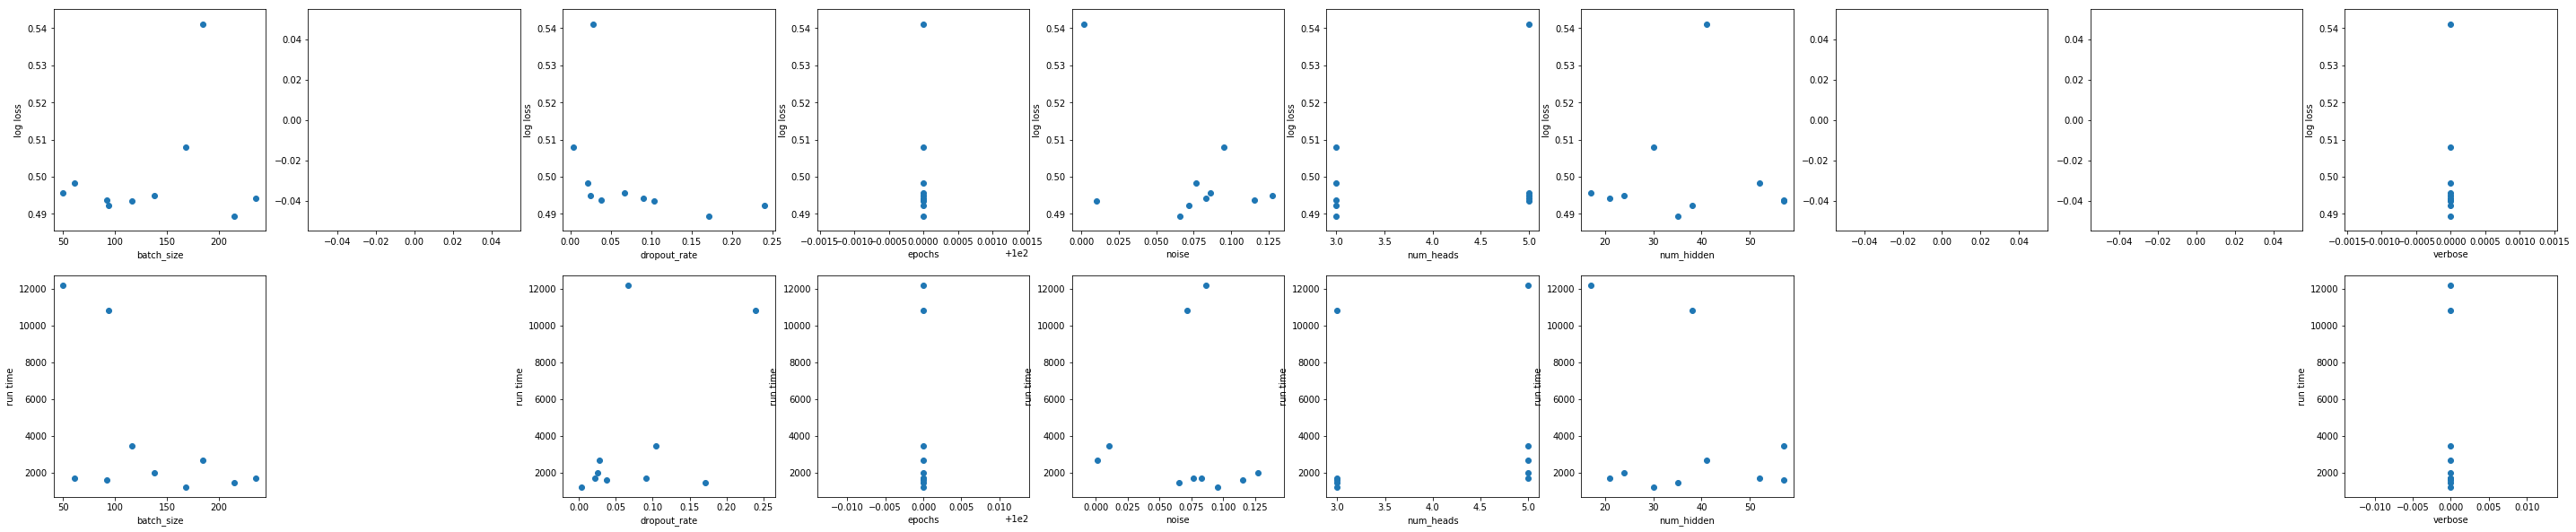

In [31]:
Plot_results(search)

In [143]:
# define a model building function, with some hyper-parameters to optimize
def Generate_RNN(num_hidden=32,optimizer='adam',num_layers=2):
    
    # load pre-trained word embeddings into an Embedding layer
    embedding_layer = keras.layers.Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
    
    # embedding model
    sequence_in = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedded_out = embedding_layer(sequence_in)
    embedding_model = keras.Model(inputs=[sequence_in], outputs=embedded_out)
    embedding_model.compile(loss='mse',optimizer=optimizer,metrics=['accuracy'])

    x_in = Input(shape=(MAX_SEQUENCE_LENGTH,embedding_matrix.shape[1]))
    x = keras.layers.SpatialDropout1D(rate=0.5)(x_in)
    
    # first RNN layer
    RNN_outs = []
    for layer in range(num_layers):
        x = keras.layers.BatchNormalization()(x)
        RNN_outs.append(keras.layers.Bidirectional(keras.layers.GRU(num_hidden,return_sequences=True))(x))
        x = RNN_outs[-1]
        x = SeqSelfAttention(attention_activation='softmax')(x)        

    # After RNNs, pool and normalize
    x = keras.layers.Add()(RNN_outs)
    x = SeqSelfAttention(attention_activation='softmax')(x) 
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.BatchNormalization()(x)

    # Readout layer
    x = keras.layers.Dense(num_hidden,activation='relu')(x)
    x = keras.layers.Dropout(rate=0.5)(x)
    
    x_out = keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = keras.Model(inputs=[x_in], outputs=[x_out])
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    
    return model,embedding_model

In [145]:
model,embedding_model = Generate_RNN(num_layers=2,num_hidden=128)

In [146]:
x_val_embedded = embedding_model.predict(x_val_encoded)
x_test_embedded = embedding_model.predict(x_test_encoded)
x_train_embedded = embedding_model.predict(x_train_encoded)

In [147]:
# define a generator function to make "mixes" of two batches, 
# with the correct label being the weighted sum of the labels
# Inspired by: https://arxiv.org/abs/1710.09412
def mixed_generator(x_train = x_train_embedded,y_train=y_train, batch_size = 64):
    
    while True:
        # shuffle the data points
        index_shuffle = np.random.permutation(x_train_embedded.shape[0])
        x_train = x_train[index_shuffle,:,:]
        y_train = y_train[index_shuffle]
        
        for i in range(0,x_train.shape[0]-batch_size*2,batch_size*2):
            x1 = x_train[i:i+batch_size,:,:]
            x2 = x_train[i+batch_size:i+batch_size*2,:,:]
            y1 = y_train[i:i+batch_size]
            y2 = y_train[i+batch_size:i+batch_size*2]
            
            lda = np.max([0,np.random.normal(loc=0.15,scale=0.05)])
            x = x1*lda + x2*(1-lda)
            y = y1*lda + y2*(1-lda)
            yield x,y

In [149]:
train_gen = mixed_generator(x_train = x_train_embedded,y_train=y_train, batch_size = 32)

In [150]:
# do an initial epoch with the non-mixed training data
model.fit(x_train_embedded,y_train,verbose=1,validation_data = [x_val_embedded,y_val],batch_size = 64)

# mix together the training data for another several epochs
val_loss = np.zeros(10)
val_acc = np.zeros(10)
for i in range(10):
    history = model.fit_generator(train_gen,
                        steps_per_epoch=y_train.size//64//2,
                        verbose=1)
    val_loss[i],val_acc[i] = model.evaluate(x=x_val_embedded,y=y_val)
    if history.history['loss'] < val_loss[i]:
        break

Train on 107560 samples, validate on 25326 samples
127/840 [===>..........................] - ETA: 3:17 - loss: 0.5116 - acc: 0.5374

KeyboardInterrupt: 

In [ ]:
plt.plot(val_loss)


### 2.1.1 Evaluating model performance
Let's take a look at where the model succeeds and fails, to help gain inutition into the performance. A list of performance metrics I'm interested in:
1. Precision (how many lines that the model thinks are "funny" are actually funny.
2. Recall (how many lines that are actually funny does the model find).
3. Example false positives and negatives.

In [231]:
y_pred = model.predict(x_val_encoded).squeeze()

def Precision(y,y_pred):
    precision = np.sum(y_pred==1 & y==0)/np.sum(y_pred)
    return precision

def Recall(y,y_pred):
    recall = np.sum(y_pred==1 & y==0)/np.sum(y_pred)
    recall = np.sum(y_pred==1)/np.sum(y==1)
    
def Pull_examples(y,y_pred,x,num_examples=3):
    # find the entries where the prediction was maximally off(either positive or negative)
    idx = np.argsort(y_pred-y)
    print('\n\n\nFALSE POSTITIVE:')
    for ex in range(num_examples):
        print(x[idx[0+ex]])
        print()
    print('\n\n\nFALSE NEGATIVE:')
    for ex in range(num_examples):
        print(x[idx[-1-ex]])
        print()

In [232]:
Pull_examples(y_val,y_pred,x_val,num_examples=3)




FALSE POSTITIVE:
 Finally, it's a contributor to CBS Sunday Morning, and the only member of our panel named after a George Michael song, it's Faith Salie.

 Well, now in a production of "Music Man," the adorable Winthrop takes the stage and sings (singing) Erie, Pa., Erie, Pa., Erie, Pa.

 ...Announced a new special offering - free blanks on February 14.




FALSE NEGATIVE:
 It was a time - he documented the 2,267 times he had sneezed. He even documented the time he sneezed while he was documenting a sneeze. Carl, how did Steve Martin do on our game?

 The Red Rover Group, the so-called only public relations firm for animals, managed to get the game Duck, Duck, Goose banned from playgrounds, daycares and schools. The game comes from the days when pioneers would sit in a circle, someone would get hit in the head with a goose and then be in charge of hunting and cooking for the night.

 ...B, the musician Rob Zombie, who says he plays Phish music to, quote, "go to my happy place," or 

## 2.2 Optimize model <a name='rnn-optimize'></a>
This time I will use a random search to optimize over several possible parameters:
1. Number of recurrent units
2. Dropout percentage
3. Batch Size

If I were to change the model architecture more dramatically, there would certainly be other choices of parameters, but this will give me an initial sense. There is an sklearn wrapper for keras which could probably be useful here. However, at the moment I don't have internet access so I can't read the documentation for it :(. So I'll just hard-code something, and perhaps come back later and change things up.

In [36]:
# support function for random_search: Select a random value for each parameter being tested
def Select_Parameters(drops_to_test,num_units_to_test,batch_size_to_test,num_dense_to_test,sequence_length_to_test):
    # randomly select parameters in the specified ranges
    drop = np.random.uniform(low = drops_to_test[0],high=drops_to_test[1])
    num_units = np.random.randint(low = num_units_to_test[0],high  = num_units_to_test[1])
    batch_size = np.random.randint(low = batch_size_to_test[0],high = batch_size_to_test[1])
    num_dense = np.random.randint(low = num_dense_to_test[0],high = num_dense_to_test[1])
    sequence_length = np.random.randint(low = sequence_length_to_test[0],high = sequence_length_to_test[1])
    
    
    # Report the conditions so we can track performance as we go
    print(f'Training model with {num_units}  units in the recurrent layer')
    print(f'Training model with dropout at {drop*100}%')
    print(f'Training model with batch size {batch_size}')
    print(f'Training model with sequence length {sequence_length}')
    print(f'Training model with {num_dense} units in the fully-connected layer')
    
    return drop,num_units,batch_size,num_dense,sequence_length

def random_search(model_fun = generate_model,
                  num_runs = 1, 
                  drops_to_test=[.1,.5],
                  num_units_to_test=[50,200],
                  batch_size_to_test = [32,240],
                  num_dense_to_test = [32,240],
                  sequence_length_to_test = [10,50],
                  patience=1,
                 ):
    
    # Callback to stop learning when the network stops improving
    early_stopping = EarlyStopping(monitor='val_loss',patience = patience, restore_best_weights=True)
    
    # Report expected baseline accuracy
    print(f'baseline accuracy is: {1-np.mean(y_train)}')
    print(f'baseline loss is: {log_loss(y_val.astype("int"),y_train.mean()*np.ones(y_val.size))}')

    
    # intialize results vector
    random_search_results = pd.DataFrame({'dropout': [],
                                    'num_units': [],
                                    'num_dense': [],
                                    'batch_size':[],
                                    'run_time_m':[],
                                    'min_val_loss':[],
                                    'val_loss':[],
                                    'val_acc':[],
                                    'train_loss':[],
                                    'train_acc':[],
                                   })
    
    # Randomly generate models with parameters in the specified ranges, and report their performance
    for run in range(num_runs):
        print(f'Run number {run}:')
        
        drop,num_units,batch_size,num_dense,sequence_length = Select_Parameters(drops_to_test,
                                                            num_units_to_test,
                                                            batch_size_to_test,
                                                            num_dense_to_test,
                                                            sequence_length_to_test)

        # Time the computation
        start = time.time()

        # Generate a model with the specified parameters
        model = model_fun(num_recurrent = num_units,drop_prob=drop,num_dense=num_dense)

        history = model.fit(x=[x_train_augmented_encoded],
                  y=y_augmented,
                  batch_size=batch_size,
                  epochs=epochs_per_lr,
                  shuffle=True,
                  validation_data = ([x_val_encoded],y_val),
                  callbacks=[early_stopping],
                  verbose=1,
             )

        # Calculate the run time
        end = time.time()

        # Save the results
        random_search_results = random_search_results.append(  
                                        {'dropout': drop,
                                        'num_units': num_units,
                                        'batch_size':batch_size,
                                        'run_time_m':(end - start)/60,
                                        'min_val_loss':min(history.history["val_loss"]),
                                        'val_loss':history.history["val_loss"],
                                        'val_acc':history.history["val_acc"],
                                        'train_loss':history.history["loss"],
                                        'train_acc':history.history["acc"],
                                         'num_dense':num_dense,
                                       },ignore_index=True)

        # Report the results
        print(f'minimum val loss is {min(history.history["val_loss"])}')
        print(f'maximum val accuracy is {max(history.history["val_acc"])}')
        print(f'Run time = {(end - start)/60} mins')
        print('')
        print('')

        # Plot the performance
        plt.plot(history.history['loss'],'b')
        plt.plot(history.history['val_loss'],'r')
        min_loss = min(history.history["val_loss"])
        
        # If this is the first run, or if this is the best model so far, save the model
        if run==0 or min_loss<best_val:
            best_model = model
            best_val = min_loss
        
    # When we have finished testing, return the results
    return random_search_results,best_model

In [37]:
# set parameter ranges to test via grid parameter search
random_search_results,best_model = random_search(model_fun = generate_model,
                                                  num_runs = 20, 
                                                  drops_to_test=[0.1,0.5],
                                                  num_units_to_test=[32,256],
                                                  batch_size_to_test = [32,256],
                                                  sequence_length_to_test = [10,100],
                                                 )

baseline accuracy is: 0.7378579397545556
baseline loss is: 0.5720979238970163
Run number 0:
Training model with 214  units in the recurrent layer
Training model with dropout at 26.602559396271015%
Training model with batch size 192
Training model with sequence length 74
Training model with 165 units in the fully-connected layer
Train on 430240 samples, validate on 25326 samples
Epoch 1/10
 73728/430240 [====>.........................] - ETA: 14:23 - loss: 0.5672 - acc: 0.7341

KeyboardInterrupt: 

In [76]:
random_search_results.sort_values(['min_val_loss']).head(10)

,dropout,num_units,num_dense,batch_size,run_time_m,min_val_loss,val_loss,val_acc,train_loss,train_acc
5,0.480034,143.0,152.0,208.0,2.768798,0.470940,"[0.5040455156358666, 0.4821566498072781, 0.483...","[0.778684635918402, 0.7886184962310848, 0.7887...","[0.4884637821966057, 0.40403453878561274, 0.39...","[0.7976054843470916, 0.848266873615663, 0.8487..."
2,0.232940,188.0,91.0,94.0,3.435988,0.473437,"[0.5571371803188255, 0.4734366087398472, 0.477...","[0.7875951650094171, 0.7855484901199951, 0.787...","[0.432898991039974, 0.3930109423480117, 0.3848...","[0.8290142095887755, 0.8480641288026207, 0.849..."
9,0.257270,209.0,65.0,241.0,2.646213,0.474413,"[0.4909754705283283, 0.47441258670297975, 0.48...","[0.7682266454906124, 0.7862723202394751, 0.788...","[0.46761122765838725, 0.3976020356964119, 0.38...","[0.8055035355172931, 0.8481703285885741, 0.848..."
0,0.305292,187.0,75.0,110.0,6.192417,0.474544,"[0.5070246809429404, 0.5059612217979546, 0.475...","[0.7887183347177404, 0.7885935369776264, 0.788...","[0.44984201756731773, 0.3987695455257642, 0.38...","[0.8220720301525489, 0.8478806641233742, 0.848..."
7,0.198362,191.0,127.0,121.0,3.059532,0.474975,"[0.4779636247854591, 0.4749747405579723, 0.482...","[0.7879945078905373, 0.7853238481655856, 0.787...","[0.4321609545246945, 0.3929390821139405, 0.383...","[0.8291976400070051, 0.8485082527868787, 0.849..."
1,0.170825,252.0,203.0,237.0,3.750361,0.477735,"[0.5100076123731764, 0.4822756840713191, 0.477...","[0.788618494142356, 0.7881692262991945, 0.7835...","[0.44598406123851125, 0.3960894197688849, 0.38...","[0.8195519906846992, 0.847108233746753, 0.8489..."
6,0.411715,65.0,134.0,155.0,2.268429,0.477853,"[0.4818878290817024, 0.47856985823456216, 0.47...","[0.7878447521436561, 0.7884936969883951, 0.787...","[0.4775980539627836, 0.4036482155302886, 0.395...","[0.806362846349558, 0.8482475634637321, 0.8484..."
8,0.223256,152.0,187.0,93.0,3.648805,0.478958,"[0.4858787860976583, 0.502092149223294, 0.4789...","[0.7847497832235082, 0.7879196304410908, 0.780...","[0.4308064011565746, 0.3931407399266236, 0.384...","[0.8312735345069651, 0.8481316977823933, 0.849..."
4,0.118791,143.0,84.0,151.0,1.696210,0.482490,"[0.4824901472030025, 0.5342482152613572, 0.487...","[0.7857731168002028, 0.7885685746847996, 0.788...","[0.4373601455003688, 0.39381394311591467, 0.38...","[0.8258569072670512, 0.8483344586519151, 0.848..."
3,0.274953,255.0,224.0,180.0,120.823574,0.488063,"[0.5157119187800816, 0.5105283856726639, 0.498...","[0.7469362272434313, 0.788893049462196, 0.7890...","[0.4466066704853467, 0.39749745058198455, 0.39...","[0.8226610036548689, 0.8482572191917402, 0.848..."


In [77]:
random_search_results.corr()['min_val_loss']

dropout        -0.380925
num_units       0.242803
num_dense       0.497649
batch_size      0.013149
run_time_m      0.750302
min_val_loss    1.000000
Name: min_val_loss, dtype: float64

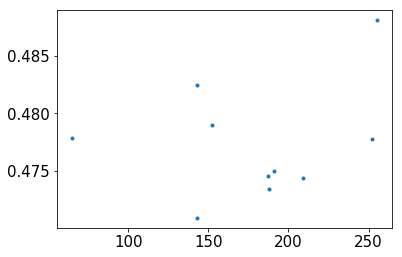

In [81]:
plt.plot(random_search_results.num_units,random_search_results.min_val_loss,'.')

# Augmenting the data: synonyms <a name=#rnn-syn></a>
In training my models so far, I'm definitely struggling with the problem of over-fitting: the model starts to "memorize" the training data, and thus performs poorly on the validation data. I can try to combat this in a few ways: regularizing the model, via dropout or imposed loss functions on the weights. Another powerful method is to generate more training data. Since my training data currently includes 10 years' worth of transcripts (and the years prior to this don't have transcripts), I'm unlikely to be able to get "new" transcripts to help train on.

Instead, I will be trying a form of text regularization: I will replace some of the words in each sentence with synonyms. This will ahve the effect of slightly changing the phrasing of many sentences, without dramatically altering the meaning. I can then learn on both the original sentences and the "altered" sentences, essentially doubling (or more) my training set. Code for replacing words with synonyms is based on this tutorial: http://rwet.decontextualize.com/book/textblob/

In [21]:
from textblob import TextBlob

# Use a dictionary of positions, to specify what part of speech a word is being used as and select better synonyms
pos_dict = {'NN':'n','NNS':'n','NNP':'n','NNPS':'n' ,
           'VB':'v', 'VBD':'v','VBG':'v','VBN':'v','VBP':'v','VBZ':'v',
           'JJ':'a','JJR':'a','JJS':'a','RB':'r','RBR':'r','RBS':'r'} # part of speech dictionary
part_of_speech_list = pos_dict.keys()
    
# Function to replace a dataset with synonyms. 
# This function will be performed num_samples times, so if I want to make 3 new sentences for every 1 input sentence,
# then num_samples should be 3
def Augment_training_set(x_train,y_train,num_samples=1,p=0.5):
    
    # initialize the augmented outputs
    y_augmented = y_train
    x_augmented = x_train
    
    # For each line, with some probability, switch up nouns, verbs, adjectives, and adverbs with synonyms
    for sample in range(num_samples):
        x_syn = Replace_synonyms(x_train,p)
        
        # combine the initial dataset and the new datasets together
        x_augmented = np.concatenate((x_augmented,x_syn))
        y_augmented = np.concatenate((y_augmented,y_train))
        
    # Finally, re-calculate the encoding so that we can feed the new sentences into our models
    [x_train_augmented_encoded,x_val_encoded],word_index = Encode_lines([x_augmented,x_val])
    embedding_matrix = Make_embedding_matrix(word_index)
    
    return x_augmented,x_train_augmented_encoded,y_augmented,x_val_encoded,embedding_matrix

# Helper function for Augment training set: replace words in x_train with synonyms with specified probability
def Replace_synonyms(x,p=0.5):
    # Use a dictionary of positions, to specify what part of speech a word is being used as and select better synonyms
    pos_dict = {'NN':'n','NNS':'n','NNP':'n','NNPS':'n' ,
               'VB':'v', 'VBD':'v','VBG':'v','VBN':'v','VBP':'v','VBZ':'v',
               'JJ':'a','JJR':'a','JJS':'a','RB':'r','RBR':'r','RBS':'r'} # part of speech dictionary
    part_of_speech_list = pos_dict.keys()
    
    x_syn = x
    for idx,line in enumerate(x):

        # Use TextBlob to identify words + part of speech
        blob = TextBlob(line)
        output = []

        # Replace nouns, verbs, adjectives, and adverbs with synonyms (with specified probability)
        for word,tag in blob.tags:
            if (len(word) > 4) and (tag in part_of_speech_list) and len(word.get_synsets(pos=pos_dict[tag])) > 0 and (np.random.rand() > p):
                random_synset = np.random.choice(word.get_synsets(pos=pos_dict[tag]))
                random_lemma = np.random.choice(random_synset.lemma_names())
                output.append(random_lemma.replace('_', ' '))
            else:
                output.append(word)
        x[idx] = ' '.join(output)
        
        if idx%10000 == 0:
            print(f'Completed synonyms of line {idx}/{len(x)}.')
    return x_syn

In [22]:
x_augmented,x_train_augmented_encoded,y_augmented,x_val_encoded,embedding_matrix = Augment_training_set(x_train,y_train,num_samples=3)


Completed synonyms of line 0/107560.
Completed synonyms of line 10000/107560.
Completed synonyms of line 20000/107560.
Completed synonyms of line 30000/107560.
Completed synonyms of line 40000/107560.
Completed synonyms of line 50000/107560.
Completed synonyms of line 60000/107560.
Completed synonyms of line 70000/107560.
Completed synonyms of line 80000/107560.
Completed synonyms of line 90000/107560.
Completed synonyms of line 100000/107560.
Completed synonyms of line 0/107560.
Completed synonyms of line 10000/107560.
Completed synonyms of line 20000/107560.
Completed synonyms of line 30000/107560.
Completed synonyms of line 40000/107560.
Completed synonyms of line 50000/107560.
Completed synonyms of line 60000/107560.
Completed synonyms of line 70000/107560.
Completed synonyms of line 80000/107560.
Completed synonyms of line 90000/107560.
Completed synonyms of line 100000/107560.
Completed synonyms of line 0/107560.
Completed synonyms of line 10000/107560.
Completed synonyms of line